# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Download Isic dataset here for fafster loading
# https://drive.google.com/file/d/1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG/view?usp=sharing
%cd /content
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG" -O rbv.zip && rm -rf /tmp/cookies.txt
!unzip -q rbv.zip -d ./

In [ ]:
#Settings
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from importlib import reload
import sys
import os
sys.path.append('/content/drive/My Drive/Mic Project/code/src')

import tensorflow as tf
import numpy as np
import callbacks

In [ ]:
%%capture
import models_r
import rbv_gen
import callbacks
import isic_gen
import pprint
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

In [ ]:
%%capture
reload(models_r);
reload(rbv_gen);
reload(callbacks);
reload(isic_gen);

# Train 128x128 patches

In [ ]:
wt = tf.constant([0.2,1.5], dtype = tf.dtypes.float32)
norm = ''
def weighted_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.dtypes.int32)
    weights = tf.gather(wt, y_true)
    if norm == 'sig':
        err = tf.nn.sparse_softmax_cross_entropy_with_logits(y_true, y_pred)
    elif norm == 'softmax':
        err = tf.nn.sparse_sigmoid_cross_entropy_with_logits(y_true, y_pred)
    else:
        err = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    err = err*weights
    return err

In [ ]:
%cd /content/
# inputs = tf.zeros((1,128,128,3))
# model = models_r.R2UNET(ch_init = 16, sig = True)
# out = model(inputs, False)

####tf exclusive
train_gen, val_gen = rbv_gen.tf_dataset('./rbv/patches/patch_img', './rbv/patches/patch_gt', batch_trn = 30, batch_val = 20, cache = 'cache0', img_wise_norm = True)
# val_gen = isic_gen.tf_dataset(batch_size = 30, center = False, cache = 'cache1')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),          
              loss= weighted_error,
              metrics=['accuracy', callbacks.F1, callbacks.SE, callbacks.SP, callbacks.JS, callbacks.DC])

/content


In [ ]:
# model.save('/content/drive/My Drive/code/retina_final_img_wise_norm')
# pickle.dump(history.history, open('/content/drive/My Drive/code/retina_final_img_wise_norm.history1.pkl', 'wb'))
history = model.fit(train_gen, steps_per_epoch = 200, epochs = 50, validation_data = val_gen, validation_steps = 50)
# history = model.fit(train_gen, steps_per_epoch = 200, epochs = 50)

Epoch 1/50
200/200 [==============================] - 63s 313ms/step - loss: 0.1360 - accuracy: 0.8433 - F1: 0.4936 - SE: 0.5342 - SP: 0.9522 - JS: 0.3937 - DC: 0.4938 - val_loss: 0.1475 - val_accuracy: 0.8403 - val_F1: 0.4206 - val_SE: 0.3959 - val_SP: 0.9649 - val_JS: 0.3298 - val_DC: 0.4208
Epoch 2/50
200/200 [==============================] - 64s 322ms/step - loss: 0.1345 - accuracy: 0.8469 - F1: 0.5014 - SE: 0.5365 - SP: 0.9568 - JS: 0.4038 - DC: 0.5017 - val_loss: 0.1459 - val_accuracy: 0.8033 - val_F1: 0.4377 - val_SE: 0.5440 - val_SP: 0.9040 - val_JS: 0.3263 - val_DC: 0.4379
Epoch 3/50
200/200 [==============================] - 63s 315ms/step - loss: 0.1329 - accuracy: 0.8515 - F1: 0.5101 - SE: 0.5408 - SP: 0.9606 - JS: 0.4143 - DC: 0.5103 - val_loss: 0.1433 - val_accuracy: 0.8408 - val_F1: 0.4431 - val_SE: 0.4233 - val_SP: 0.9619 - val_JS: 0.3450 - val_DC: 0.4433
Epoch 4/50
200/200 [==============================] - 63s 315ms/step - loss: 0.1321 - accuracy: 0.8538 - F1: 0.5194

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, -1)
    # pred_mask = pred_mask[..., tf.newaxis]
    # print(pred_mask.shape)
    return pred_mask

In [ ]:
val_it = iter(val_gen)

In [ ]:
k = next(val_it)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


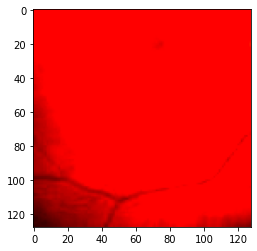

In [ ]:
plt.imshow(k[0][0])

In [ ]:
out = model.predict(k[0])

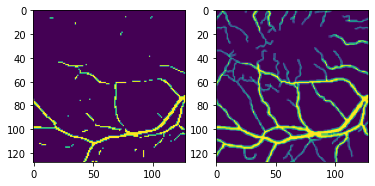

In [ ]:
plt.subplot(121)
plt.imshow(create_mask(out[0]))
plt.subplot(122)
plt.imshow(k[1][0])

In [ ]:
from PIL import Image
test_img = []
# test_mask = []
test_files = [os.path.abspath(os.path.join('/content/rbv/test', i)) for i in os.listdir('/content/rbv/test')]
for i in test_files:
    test = np.asarray(Image.open(i), dtype = "float32") / 255.
    patches = tf.image.extract_patches(test[tf.newaxis, ...], [1,128,128,1], strides = [1,128,128,1], rates = [1,1,1,1], padding = 'VALID')
    inputs = tf.map_fn(tf.image.per_image_standardization, tf.reshape(patches, (4, 128, 128, 3)))
    outputs = create_mask(model.predict(inputs))
    mask = tf.concat([ tf.concat([outputs[0], outputs[1]], axis = 1) , tf.concat([outputs[2], outputs[3]], axis = 1)], axis = 0 )
    test_img.append(test)
    test_mask.append(mask)

In [ ]:
i = 0
%cd /content/drive/My\ Drive/data/
!mkdir rbv_test_res
%cd rbv_test_res
!mkdir test2
%cd test2

for i in range(len(test_img)):
    tf.keras.preprocessing.image.array_to_img(test_img[i]).save('img%d.jpg'%i)
    tf.keras.preprocessing.image.array_to_img(test_mask[i][..., tf.newaxis]).save('mask%d.jpg'%i)
    # plt.subplot(121)
    # plt.imshow(test_img[i])
    # plt.subplot(122)
    # plt.imshow(test_mask[i], cmap = 'gray')
# test_ma
%cd /content/

/content/drive/My Drive/data
mkdir: cannot create directory ‘rbv_test_res’: File exists
/content/drive/My Drive/data/rbv_test_res
mkdir: cannot create directory ‘test2’: File exists
/content/drive/My Drive/data/rbv_test_res/test2
/content


# Train 64x64 patches

In [ ]:
reload(rbv_gen)
train_gen, val_gen = rbv_gen.tf_dataset_real_time('/content/rbv/', shape = (64,64,1), batch_trn = 30, batch_val = 20,center = True)

True
reading images...
calculating mean...
calculating std dev...
normalizing images
getting patches ...
init shape: (68, 20, 20, 4096) reshaping into: (27200, 64, 64, 1)
reshping tensors ...
shape after: (27200, 64, 64, 1)
total ptaches: 27200
trn_patches: 21760
preparing datasets...
complete...


In [ ]:
wt = tf.constant([1,25], dtype = tf.dtypes.float32)
norm = ''
def weighted_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.dtypes.int32)
    weights = tf.gather(wt, y_true)
    if norm == 'sig':
        err = tf.nn.sparse_softmax_cross_entropy_with_logits(y_true, y_pred)
    elif norm == 'softmax':
        err = tf.nn.sparse_sigmoid_cross_entropy_with_logits(y_true, y_pred)
    else:
        err = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    err = err*weights
    return tf.reduce_mean(err)

In [ ]:
inputs = tf.zeros((1, 64, 64, 1))
model = models_r.R2UNET(ch_init = 16, t = 3, depth = 4)
out = model(inputs, False)
model.summary()

Model: "r2unet_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rec_block_109 (rec_block)    multiple                  4800      
_________________________________________________________________
rec_block_110 (rec_block)    multiple                  19296     
_________________________________________________________________
rec_block_111 (rec_block)    multiple                  76480     
_________________________________________________________________
rec_block_112 (rec_block)    multiple                  304512    
_________________________________________________________________
rec_block_113 (rec_block)    multiple                  1215232   
_________________________________________________________________
de_conv_52 (de_conv)         multiple                  4688      
_________________________________________________________________
de_conv_53 (de_conv)         multiple                  18

In [ ]:

# batch_stats = callbacks.CustomCallback();

# mean_ = isic_gen.find_mean(isic_gen.abs_train_img)
# std_dev_ = isic_gen.find_std_dev(isic_gen.abs_train_img, mean_)

####tf exclusive
# val_gen = isic_gen.tf_dataset(batch_size = 30, center = False, cache = 'cache1')

####general
# train_gen = isic_gen.data_gen(batch_size = 20, norm = True)
# val_gen = isic_gen.data_gen(isic_gen.abs_val_img, isic_gen.abs_val_mask, 10, norm = True, mean_ = mean_ , std_dev_ = std_dev_)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),          
              loss = weighted_error,
              metrics=['accuracy', callbacks.F1, callbacks.SE, callbacks.SP, callbacks.JS, callbacks.DC])

#history
#

In [ ]:
history1 = model.fit(train_gen, steps_per_epoch = 700, epochs = 150, validation_data = val_gen, validation_steps = 100)
model.save('content/drive/My Drive/code/rbv_last0')

Epoch 1/150
700/700 [==============================] - 157s 224ms/step - loss: 0.9459 - accuracy: 0.7455 - val_loss: 0.4729 - val_accuracy: 0.8498
Epoch 2/150
700/700 [==============================] - 156s 223ms/step - loss: 0.8833 - accuracy: 0.7910 - val_loss: 0.4599 - val_accuracy: 0.8443
Epoch 3/150
700/700 [==============================] - 155s 222ms/step - loss: 0.8645 - accuracy: 0.7826 - val_loss: 0.4069 - val_accuracy: 0.9329
Epoch 4/150
510/700 [====================>.........] - ETA: 41s - loss: 0.7338 - accuracy: 0.8096

In [ ]:

pickle.dump(history.history, open('/content/drive/My Drive/code/history_rbv_final0.pkl'))

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, -1)
    # pred_mask = pred_mask[..., tf.newaxis]
    # print(pred_mask.shape)
    return pred_mask

In [ ]:
val_it = iter(train_gen)

In [ ]:
k = next(val_it)

In [ ]:
plt.imshow(tf.reshape(k[0][0],(64,64)))

In [ ]:
out = model.predict(k[0])

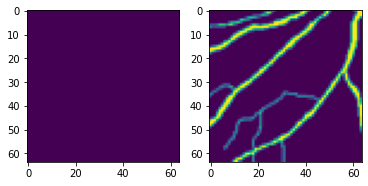

In [ ]:
plt.subplot(121)
plt.imshow(create_mask(out[0]))
plt.subplot(122)
plt.imshow(k[1][0])

In [ ]:
k[0].shape

TensorShape([10, 64, 64, 1])

In [ ]:
k[1].shape

TensorShape([10, 64, 64])

In [ ]:
k[0][0].shape

TensorShape([64, 64, 3])

In [ ]:
k[1][0]

<tf.Tensor: shape=(64, 64), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
unet_acc = history1.history['acc']
unet_val_acc = history1.history['val_acc']
r2unet_acc = history1.history['acc']
r2unet_val_acc = history1.history['val_acc']

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.ylim([0.7,1])
plt.plot(unet_acc, label='Training Accuracy, U-Net' )
plt.plot(unet_val_acc, label='Validation Accuracy, U-Net')
plt.plot(r2unet_acc, label='Training Accuracy, R2U-Net' )
plt.plot(r2unet_val_acc, label='Validation Accuracy, R2U-Net')
plt.legend(loc='lower right')
plt.show()
plt.savefig('/content/drive/My Drive/data/isicgraphs/graph_1.png')

In [ ]:
import matplotlib.pyplot as plt

train_it = iter(train_gen) 
k = next(train_it)
out1 = model1.predict(k[0])
out2 = model2.predict(k[0])

def create_mask(pred_mask):
    pred_mask = tf.cast(tf.argmax(pred_mask, -1), tf.dtypes.float32)
    return pred_mask

for i in range(5):
    plt.figure()
    plt.imshow(k[0][i])
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/isicplots/orig_{i}.png')
    plt.figure()
    plt.imshow(k[1][i], cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/isicplots/ground_{i}.png')
    plt.figure()
    ok1 = create_mask(out1[i])
    plt.imshow(ok1, cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/isicplots/unet{i}.png')
    plt.figure()
    ok2 = create_mask(out2[i])
    plt.imshow(ok2, cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/isicplots/r2unet{i}.png')